# Task solution

At the moment I would like to share my understanding of a task, as far as I understand the idea is to forecast a power and other features using given data, If I am correct and my solution suits you then we can proceed forward (extending the method for other features or having a meet)

## Approach
1. I read all cycles data for all hours folders and concatenated it in correct order.
2. I train a NLinear model because it wins in a lot of benchmarks on [Papers with code](https://paperswithcode.com/task/time-series-forecasting) and is conveniently implemented in darts Python module.
3. Below I present a results of a model forecast in comparison with real data.

In [2]:
import os

import darts
from darts.models.forecasting.nlinear import NLinearModel

import plotly.graph_objects as go
from IPython.display import Image

from utils import read_all_cycles

DATA_FOLDER = os.path.join('.', 'output')
MODEL_FOLDER = os.path.join('.', 'models')

In [3]:
# This function reads all data
df_h = read_all_cycles(DATA_FOLDER)

# Reset the index, as each cycle df had it's own index, now it's a single index for all data
power_df = df_h[['power']].reset_index(drop=True)

# Use one sixth for validation, everyting else for training
split_point = int(5 / 6 * len(power_df))

series = darts.TimeSeries.from_dataframe(power_df, value_cols='power')
train, val = series[:split_point], series[split_point:]

In [4]:
# I load pretrained model as I used separate file for training and it's not relevant atm
model = NLinearModel.load(os.path.join(MODEL_FOLDER, 'nlinear_full_data_1024_512.pkl'))

In [5]:
prediction = model.predict(len(val))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/hdd1/anaconda3/envs/crossing_minds_best/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


# All data

On this chart you can see all available data and predictions, basically model only had data before the predictions started, so the task over here is to evaluate how much the predictions differ from the real data.

Basically the model isn't doing very well in a long term, also I present MAE metric, it's not fully representable of quality of forecast but for this stage I think it's enough.

MAE of results is: 5.727314139162798


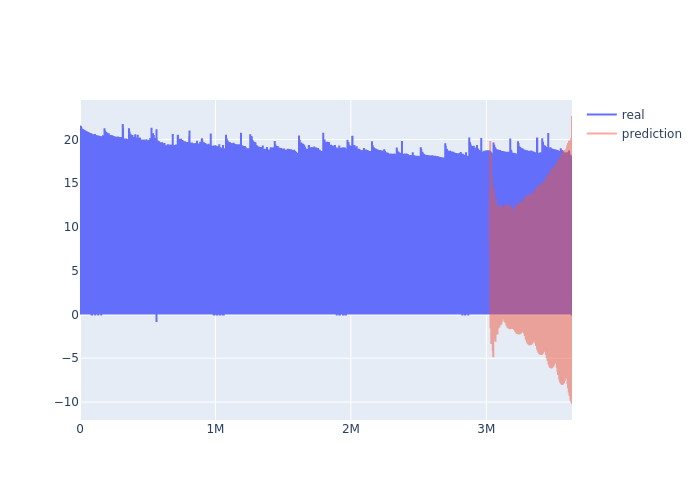

In [8]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=[item for item in range(len(power_df))],
        y=power_df.values.squeeze(),
        mode='lines',
        name='real'
    )
)

fig.add_trace(
    go.Scatter(
        x=[item for item in range(len(train), len(train) + len(prediction))],
        y=prediction.values().squeeze(),
        mode='lines',
        name='prediction',
        opacity=0.5
    )
)

print(f'MAE of results is: {darts.metrics.metrics.mae(val, prediction)}')

img_bytes = fig.to_image(format="png")
Image(img_bytes)

# Small range forecast

Yet the model is much better at forecasting for a smaller range, as we can see the first 5,000 predictions look much better.

MAE of results is: 1.2445087924844442


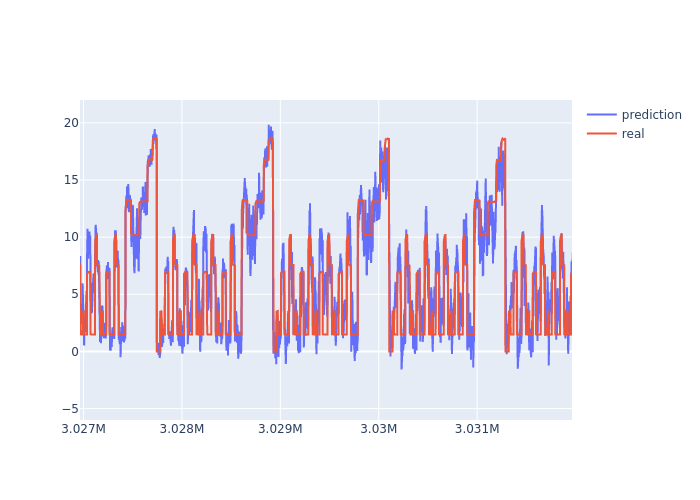

In [9]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=[item for item in range(len(train), len(train) + len(prediction))],
        y=prediction.values().squeeze(),
        mode='lines',
        name='prediction'
    )
)

fig.add_trace(
    go.Scatter(
        x=power_df.index,
        y=power_df.values.squeeze(),
        mode='lines',
        name='real'
    )
)

fig.update_xaxes(range=[len(train), len(train) + 5000])
fig.update_yaxes(range=[-6, 22])

print(f'MAE of results is: {darts.metrics.metrics.mae(val[:5000], prediction[:5000])}')

img_bytes = fig.to_image(format="png")
Image(img_bytes)